# <u> Hybrid CNN- RNN Model for Classification of Hyperspectral Satelite Images </u>
The following model uses hybrid CNN- RNN model for classification of each pixel to its corresponding classes. Further the code is developed to classify pixels in accordance with soft as well as hard classification techniques.<br>
1.) <b>HARD CLASSIFICATION </b>: A pixel strictly belongs to a single class. <br>
2.) <b>SOFT CLASSIFICATION </b>: A pixel may belong to more than one class based on its membership value. <br><br>

## <u> Importing necessary libraries and supporting files </u> 
<b>NOTE</b>- 'utils' is a supporting .py file which contains all the functions used in the notebook

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from keras.layers import Dense, Conv1D, Input, MaxPooling1D, Flatten, Dropout, LSTM
from keras import Sequential
from keras.utils import np_utils
from PIL import Image
import array
import sys
import os
from utils import hdr_read, ReadBilFile, thresholding, linear_stretch, display_save_image, extract_membership
seed = 7
np.random.seed(seed)


Using TensorFlow backend.


## <u> User Defined Parameters -  </u>
1.)<b>Header File</b>: Contains the information about the image file such as - Datatype, Number of Rows and Columns, Total number of bands etc <br>
2.)<b>Image File</b>: The information extracted from header file(with extension .hdr) is used to extract the hyperspectral image from the Image File <br>
3.)<b>Training Data</b>: Training data consists of the value of pixel from each band for a particular class <br> 
4.)<b>Epochs(model training)</b>: Number of iterations required to train the model. A lower value of epochs may lead to underfitting while a very high value may lead to overfitting of dataset, thus the choise of epochs is a crusial factor <br>
5.)<b>Selected class and Threshold value(soft classification))</b>: For the purpose of soft classification user needs to specify the threshold value (it acts as a limit, the pixels having values above that value are only classifies while pixels below it are assigned a NULL value) <br>

In [2]:
# User defined inputs
header_name = r"C:\Users\HP DV-6\Desktop\final_project\subfebformosat2.hdr"
file_name = r"C:\Users\HP DV-6\Desktop\final_project\subfebformosat2"

directory = r'C:\Users\HP DV-6\Desktop\final_project\Data'

epoch = '1000'

threshold = '0.8'

category = 'Clay'

In [3]:
# The functions are used for the conversion of string to integer and float values
# Further the directory path is corrected 
epoch = int(epoch)
threshold = float(threshold)

directory = directory.replace(os.sep, '/')
directory = directory + '/'

header_name = header_name.replace(os.sep, '/')

file_name = file_name.replace(os.sep, '/')

In [4]:
row, col, bands, datatype = hdr_read(header_name)
x_test = ReadBilFile(file_name, bands, row*col)
x_test = x_test.reshape(row*col, bands, 1)
x_test = x_test / 2**8-1

y_test = np.zeros([row*col], dtype=np.uint8)   #Each pixel will belong to one class, so total no. of outputs=rows*columns

255 uint8


In [5]:
items = os.listdir(directory)
path = items
c_c = len(path)
c_l = {items[i] : i for i in range(0, len(items))}

values = []
clicks={}

for address in path:          # function to know the total number of clicks of each class
    with open(directory+address, "rb") as f:
        k = len(f.read())
        clicks[address] = (k // 2 // bands) if (k // 2 // bands) < 400 else (k // 2 // bands) // 4
        print('{} ==> {}'.format(address, clicks[address]))

for address in path:          # function (VALUES) returns the value of all the pixels (len(values) = total_clicks * 4)
    with open(directory+address, "rb") as f:
        b = array.array("H")
        b.fromfile(f, clicks[address]*bands)
        if sys.byteorder == "little":
            b.byteswap()
        for v in b:
            values.append(v)

Clay ==> 22
Dalforest ==> 23
EuFinal ==> 8
Grassland ==> 27
Water ==> 36
Wheat ==> 27


In [6]:
# Creation of training set
ll = (len(values))       # = total_clicks * 4
rex = ll // bands        # = total clicks


# Features
f_in = np.zeros([ll], dtype=np.uint8)
x = 0
for i in range(ll):
    f_in[x] = values[i]
    x += 1
    
x_train = f_in.reshape(rex, bands)
x_train = x_train / 2**8-1          # Normalising dataset to facilitate fast training

# Labels
y_train = np.zeros([rex], dtype=np.uint8)
mark = 0                              # Creating label file (Mark does bifurcation of each class)
for add in path:                      #  outer loop iterates over each class
    for i in range(clicks[add]):      # Inner loop assigns 1, 2, 3 based on c_1 dictionary to each pixel location
        y_train[mark+i] = c_l[add]
    mark = mark + clicks[add]

In [7]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
n_classes = c_c
y_test_new = np.zeros([row * col, c_c], dtype=np.uint8)


X = x_train.reshape(x_train.shape[0], bands, 1)

## <u> Structuring Model and defining model parameters
<b>KERAS FRAMEWORK</b> is used for the implementation of the model. The model consists of successive 1 dimensional Convolution and LSTM layers followed by Max Pooling layers. <br><br>
<b><u>Convolution Neural Network:</u></b> Convolutional Neural Networks, or CNNs were originally designed to map image data to an output variable.
They have proven so effective that they are the go-to method for any type of prediction problem involving image data as an input. More generally, CNNs work well with data that has a spatial relationship. <br>
<b><u>Recurrent Neural Network:</u></b> Recurrent Neural Networks, or RNNs, were designed to work with sequence prediction problems. RNNs in general and LSTMs in particular have received the most success when working with sequences of words and paragraphs, generally called natural language processing. However they can be used for variety of other aplications such as image processing as well

In [8]:
model = Sequential()

model.add(Conv1D(32, 4, activation='relu', padding='same', input_shape=(4, 1)))
model.add(LSTM(32, return_sequences=True))
model.add(MaxPooling1D(2))
model.add(Conv1D(16, 8, activation="relu", padding='same'))
model.add(LSTM(64, return_sequences=True))
model.add(MaxPooling1D(2))
model.add(Conv1D(16, 8, activation="relu", padding='same'))
model.add(LSTM(128))
model.add(Dense(n_classes, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


### Model compilation and summary

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 4, 32)             160       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 32)             8320      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 16)             4112      
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 64)             20736     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             8208      
__________

### Training the model

In [10]:
history = model.fit(X, y_train, batch_size=10, epochs=epoch)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
143/143 [==============================] - 8s 55ms/step - loss: 1.7908 - acc: 0.2448
Epoch 2/1000
143/143 [==============================] - 0s 2ms/step - loss: 1.7872 - acc: 0.2517
Epoch 3/1000
143/143 [==============================] - 0s 2ms/step - loss: 1.7827 - acc: 0.2517
Epoch 4/1000
143/143 [==============================] - 0s 2ms/step - loss: 1.7694 - acc: 0.2517
Epoch 5/1000
143/143 [==============================] - 0s 2ms/step - loss: 1.7414 - acc: 0.2517
Epoch 6/1000
143/143 [==============================] - 0s 2ms/step - loss: 1.7119 - acc: 0.2517
Epoch 7/1000
143/143 [==============================] - 0s 2ms/step - loss: 1.7009 - acc: 0.2517
Epoch 8/1000
143/143 [==============================] - ETA: 0s - loss: 1.6771 - acc: 0.261 - 0s 2ms/step - loss: 1.6779 - acc: 0.2517
Epoch 9/1000
143/143 [==============================] - 0s 2ms/step - loss: 1.6418 - acc: 0.2517
Epoch 10/1000
143/143 [=================

143/143 [==============================] - 0s 2ms/step - loss: 0.1272 - acc: 0.9441
Epoch 81/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1286 - acc: 0.9441
Epoch 82/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1275 - acc: 0.9441A: 0s - loss: 0.1246 - acc: 0.95
Epoch 83/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1269 - acc: 0.9441
Epoch 84/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1307 - acc: 0.9441
Epoch 85/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1277 - acc: 0.9441
Epoch 86/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1259 - acc: 0.9441
Epoch 87/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1261 - acc: 0.9441
Epoch 88/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1261 - acc: 0.9441
Epoch 89/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1257 - acc: 0.9441
Ep

143/143 [==============================] - ETA: 0s - loss: 0.1302 - acc: 0.938 - 0s 2ms/step - loss: 0.1226 - acc: 0.9441
Epoch 162/1000
143/143 [==============================] - ETA: 0s - loss: 0.1229 - acc: 0.946 - 0s 2ms/step - loss: 0.1231 - acc: 0.9441
Epoch 163/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1236 - acc: 0.9441
Epoch 164/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1226 - acc: 0.9441
Epoch 165/1000
143/143 [==============================] - ETA: 0s - loss: 0.1157 - acc: 0.950 - 0s 2ms/step - loss: 0.1249 - acc: 0.9441
Epoch 166/1000
143/143 [==============================] - ETA: 0s - loss: 0.1292 - acc: 0.9538- ETA: 0s - loss: 0.1129 - acc: 0.96 - 0s 2ms/step - loss: 0.1331 - acc: 0.9441
Epoch 167/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1292 - acc: 0.9441
Epoch 168/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1276 - acc: 0.9441
Epoch 169/1000
143/143 [==========

143/143 [==============================] - 0s 2ms/step - loss: 0.1207 - acc: 0.9441
Epoch 240/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1252 - acc: 0.9441
Epoch 241/1000
143/143 [==============================] - 0s 2ms/step - loss: 1.2689 - acc: 0.7622
Epoch 242/1000
143/143 [==============================] - 0s 2ms/step - loss: 1.6373 - acc: 0.6573
Epoch 243/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.5366 - acc: 0.7902
Epoch 244/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.2273 - acc: 0.9301
Epoch 245/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1666 - acc: 0.9441
Epoch 246/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1438 - acc: 0.9441
Epoch 247/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1383 - acc: 0.9441
Epoch 248/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1329 - acc: 0.9441
Epoch 249/1000
143/143 [=

143/143 [==============================] - 0s 2ms/step - loss: 0.1415 - acc: 0.9441
Epoch 321/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1253 - acc: 0.9441
Epoch 322/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1264 - acc: 0.9441
Epoch 323/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1226 - acc: 0.9441
Epoch 324/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1216 - acc: 0.9441
Epoch 325/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1223 - acc: 0.9441
Epoch 326/1000
143/143 [==============================] - ETA: 0s - loss: 0.1270 - acc: 0.942 - 0s 2ms/step - loss: 0.1244 - acc: 0.9441
Epoch 327/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1248 - acc: 0.9441
Epoch 328/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1211 - acc: 0.9441A: 0s - loss: 0.1085 - acc: 0.9
Epoch 329/1000
143/143 [==============================]

143/143 [==============================] - 0s 2ms/step - loss: 0.1271 - acc: 0.9441
Epoch 400/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1275 - acc: 0.9441
Epoch 401/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1236 - acc: 0.9441
Epoch 402/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1275 - acc: 0.9441
Epoch 403/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1273 - acc: 0.9441
Epoch 404/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1315 - acc: 0.9441
Epoch 405/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1271 - acc: 0.9441
Epoch 406/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1248 - acc: 0.9441
Epoch 407/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1272 - acc: 0.9441
Epoch 408/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1296 - acc: 0.9441
Epoch 409/1000
143/143 [=

143/143 [==============================] - 0s 2ms/step - loss: 0.2985 - acc: 0.8601
Epoch 480/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1635 - acc: 0.9441
Epoch 481/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1243 - acc: 0.9441
Epoch 482/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1224 - acc: 0.9441
Epoch 483/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1216 - acc: 0.9441
Epoch 484/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1211 - acc: 0.9441
Epoch 485/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1212 - acc: 0.9441
Epoch 486/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1213 - acc: 0.9441
Epoch 487/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1210 - acc: 0.9441A: 0s - loss: 0.1346 - acc: 0.93
Epoch 488/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1222 - acc: 

143/143 [==============================] - 0s 2ms/step - loss: 0.1241 - acc: 0.9441
Epoch 560/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1243 - acc: 0.9441A: 0s - loss: 0.1413 - acc: 0.94
Epoch 561/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1235 - acc: 0.9441A: 0s - loss: 0.1295 - acc: 0.94
Epoch 562/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1219 - acc: 0.9441
Epoch 563/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1233 - acc: 0.9441
Epoch 564/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1209 - acc: 0.9441
Epoch 565/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1229 - acc: 0.9441
Epoch 566/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1211 - acc: 0.9441
Epoch 567/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1324 - acc: 0.9441
Epoch 568/1000
143/143 [==============================] - 0s

143/143 [==============================] - 0s 2ms/step - loss: 0.1190 - acc: 0.9441
Epoch 640/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1200 - acc: 0.9441
Epoch 641/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1201 - acc: 0.9441
Epoch 642/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1153 - acc: 0.9441A: 0s - loss: 0.1083 - acc: 0.
Epoch 643/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1147 - acc: 0.9441
Epoch 644/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1126 - acc: 0.9441
Epoch 645/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1192 - acc: 0.9441
Epoch 646/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1167 - acc: 0.9441
Epoch 647/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1134 - acc: 0.9441
Epoch 648/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1114 - acc: 0.

143/143 [==============================] - 0s 2ms/step - loss: 0.1278 - acc: 0.9441
Epoch 720/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1264 - acc: 0.9441
Epoch 721/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1240 - acc: 0.9441
Epoch 722/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1201 - acc: 0.9441
Epoch 723/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1270 - acc: 0.9441
Epoch 724/1000
143/143 [==============================] - ETA: 0s - loss: 0.1120 - acc: 0.950 - 0s 2ms/step - loss: 0.1198 - acc: 0.9441
Epoch 725/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1204 - acc: 0.9441
Epoch 726/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1143 - acc: 0.9441
Epoch 727/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1203 - acc: 0.9441
Epoch 728/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1182 -

143/143 [==============================] - 0s 2ms/step - loss: 0.1284 - acc: 0.9441
Epoch 799/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1269 - acc: 0.9441
Epoch 800/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1255 - acc: 0.9441
Epoch 801/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1243 - acc: 0.9441
Epoch 802/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1242 - acc: 0.9441
Epoch 803/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1240 - acc: 0.9441
Epoch 804/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1238 - acc: 0.9441
Epoch 805/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1243 - acc: 0.9441
Epoch 806/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1249 - acc: 0.9441
Epoch 807/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1242 - acc: 0.9441
Epoch 808/1000
143/143 [=

143/143 [==============================] - 0s 2ms/step - loss: 0.1049 - acc: 0.9441
Epoch 879/1000
143/143 [==============================] - ETA: 0s - loss: 0.1009 - acc: 0.942 - 0s 2ms/step - loss: 0.1014 - acc: 0.9441
Epoch 880/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1116 - acc: 0.9441
Epoch 881/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1263 - acc: 0.9441
Epoch 882/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1272 - acc: 0.9441
Epoch 883/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1255 - acc: 0.9441
Epoch 884/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1254 - acc: 0.9441
Epoch 885/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1249 - acc: 0.9441
Epoch 886/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1249 - acc: 0.9441
Epoch 887/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1243 -

143/143 [==============================] - 0s 2ms/step - loss: 0.1248 - acc: 0.9441
Epoch 958/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1243 - acc: 0.9441
Epoch 959/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1233 - acc: 0.9441
Epoch 960/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1223 - acc: 0.9441
Epoch 961/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1210 - acc: 0.9441
Epoch 962/1000
143/143 [==============================] - ETA: 0s - loss: 0.1211 - acc: 0.942 - 0s 2ms/step - loss: 0.1186 - acc: 0.9441
Epoch 963/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1207 - acc: 0.9441
Epoch 964/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1213 - acc: 0.9441
Epoch 965/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1140 - acc: 0.9441
Epoch 966/1000
143/143 [==============================] - 0s 2ms/step - loss: 0.1214 -

## <u> Hard Classification </u> 
In hard classification each pixel belongs to one category only

<IPython.core.display.Javascript object>


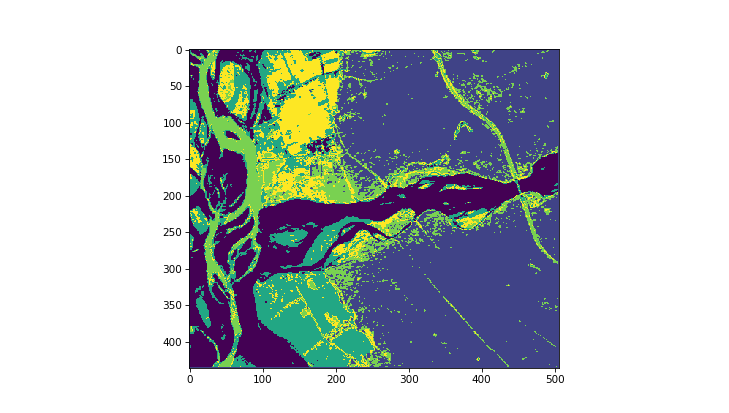

In [11]:
%matplotlib notebook
y_test_new = model.predict(x_test, batch_size=50)
y_test1 = np.argmax(y_test_new, axis=1)

display_save_image(y_test1, row, col, 'hard_classified')

## <u> Soft Classification </u> 
In soft classification a pixel may belong to more than one class based on their membership values.

Class number:  0


<IPython.core.display.Javascript object>


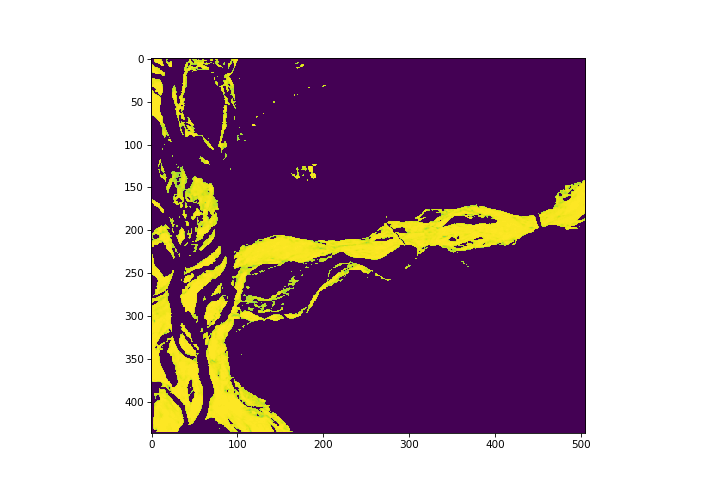

In [12]:
%matplotlib notebook
arg = c_l[category]
print('Class number: ', arg)
y1 = extract_membership(y_test_new, arg)
y1_th = thresholding(y1, threshold)
y1_std = linear_stretch(y1_th)

strg = category
name = 'soft'+ strg

display_save_image(y1_std, row, col, name)